In [0]:
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import BatchNormalization
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.utils.vis_utils import plot_model

In [6]:
!git clone https://www.github.com/keras-team/keras-contrib.git

Cloning into 'keras-contrib'...
remote: Enumerating objects: 3634, done.
remote: Total 3634 (delta 0), reused 0 (delta 0), pack-reused 3634
Receiving objects: 100% (3634/3634), 861.24 KiB | 1.96 MiB/s, done.
Resolving deltas: 100% (2330/2330), done.


In [8]:
!python setup.py install

running install
running bdist_egg
running egg_info
creating keras_contrib.egg-info
writing keras_contrib.egg-info/PKG-INFO
writing dependency_links to keras_contrib.egg-info/dependency_links.txt
writing requirements to keras_contrib.egg-info/requires.txt
writing top-level names to keras_contrib.egg-info/top_level.txt
writing manifest file 'keras_contrib.egg-info/SOURCES.txt'
writing manifest file 'keras_contrib.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/keras_contrib
copying keras_contrib/__init__.py -> build/lib/keras_contrib
creating build/lib/keras_contrib/callbacks
copying keras_contrib/callbacks/__init__.py -> build/lib/keras_contrib/callbacks
copying keras_contrib/callbacks/snapshot.py -> build/lib/keras_contrib/callbacks
copying keras_contrib/callbacks/tensorboard.py -> build/lib/keras_contrib/callbacks
copying keras_contrib/callbacks/dead_relu_detector.py

In [4]:
!pip install keras_contrib

ERROR: Could not find a version that satisfies the requirement keras_contrib (from versions: none)
ERROR: No matching distribution found for keras_contrib


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 128)       131200    
_________________________________________________________________
instance_normalization_4 (In (None, 64, 64, 128)       256       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 256)       5245

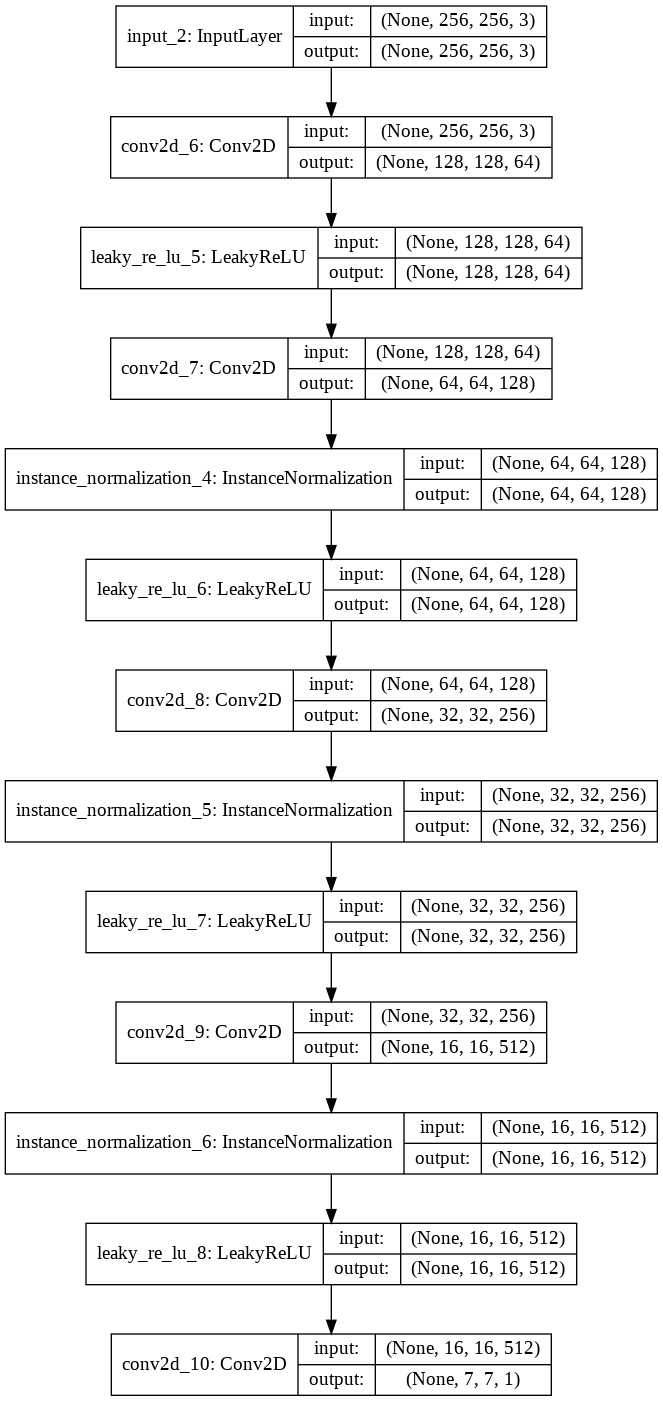

In [11]:
def define_discriminator(image_shape):
  init =RandomNormal(stddev=0.02)
  in_image=Input(shape=image_shape)
  d=Conv2D(64,(4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
  d=LeakyReLU(alpha=0.2)(d)
 
  d=Conv2D(128,(4,4), strides=(2,2), padding='same' , kernel_initializer=init)(d)
  d=InstanceNormalization(axis=-1)(d)
  d=LeakyReLU(alpha=0.2)(d)

  d=Conv2D(256,(4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d=InstanceNormalization(axis=-1)(d)
  d=LeakyReLU(alpha=0.2)(d)

  d=Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d=InstanceNormalization(axis=-1)(d)
  d=LeakyReLU(alpha=0.2)(d)

  patch_out=Conv2D(1,(4,4), strides=(2,2), kernel_initializer=init)(d)
  model=Model(in_image, patch_out)
  model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
  return model

image_shape=(256,256,3)
model=define_discriminator(image_shape)
model.summary()
plot_model(model, to_file='discriminator_model_plot.png', show_shapes=True,show_layer_names=True)


In [0]:
def resnet_block(n_filters, input_layer):
  init=RandomNormal(stddev=0.02)
  g=Conv2D(n_filters,(3,3), padding='same', kernel_initializer=init)(input_layer)
  g=InstanceNormalization(axis=-1)(g)
  g=Activation('relu')(g)

  g=Conv2D(n_filters,(3,3), padding='same', kernel_initializer=init)(g)
  g=InstanceNormalization(axis=-1)(g)

  g=Concatenate()([g, input_layer])
  return g

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 256, 256, 64) 9472        input_4[0][0]                    
__________________________________________________________________________________________________
instance_normalization_28 (Inst (None, 256, 256, 64) 128         conv2d_32[0][0]                  
__________________________________________________________________________________________________
activation_13 (Activation)      (None, 256, 256, 64) 0           instance_normalization_28[0][0]  
____________________________________________________________________________________________

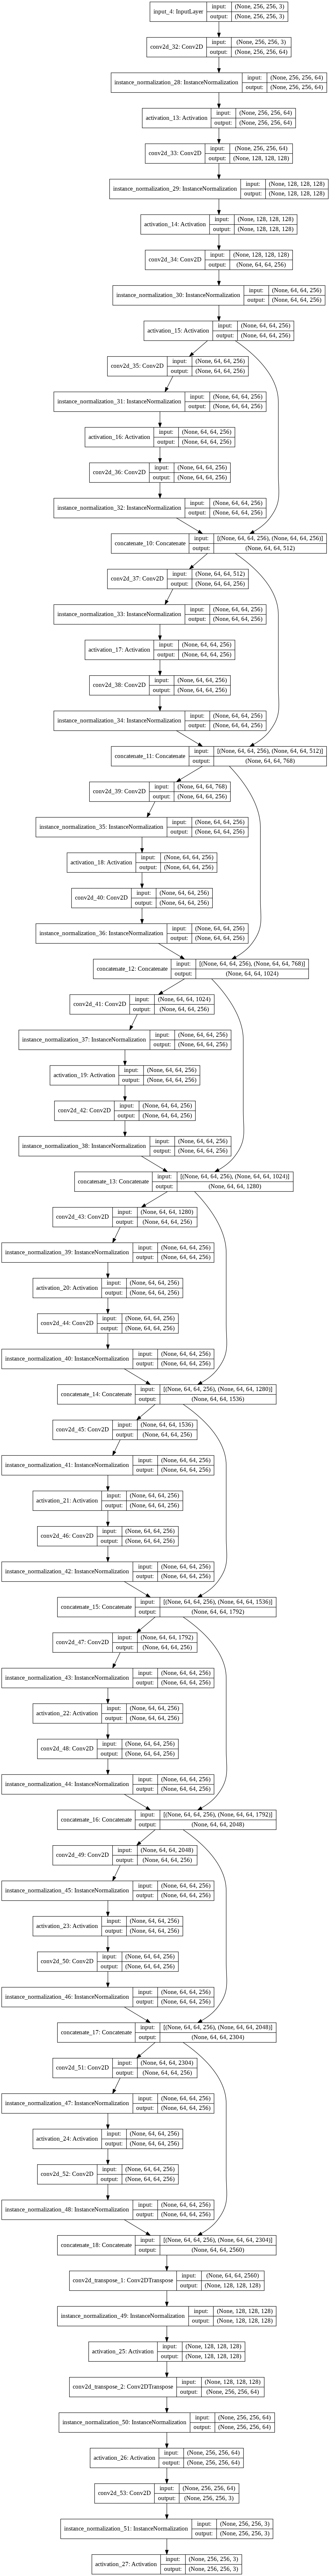

In [16]:
def define_generator(image_shape=(256,256,3), n_resnet=9):
  init=RandomNormal(stddev=0.02)
  in_image=Input(shape=image_shape)

  g=Conv2D(64,(7,7), padding='same', kernel_initializer=init)(in_image)
  g=InstanceNormalization(axis=-1)(g)
  g=Activation('relu')(g)

  g=Conv2D(128,(3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g=InstanceNormalization(axis=-1)(g)
  g=Activation('relu')(g)

  g=Conv2D(256,(3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g=InstanceNormalization(axis=-1)(g)
  g=Activation('relu')(g)

  for _ in range(9):
    g=resnet_block(256,g)
  
  g=Conv2DTranspose(128,(3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g=InstanceNormalization(axis=-1)(g)
  g=Activation('relu')(g)

  g=Conv2DTranspose(64,(3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g=InstanceNormalization(axis=-1)(g)
  g=Activation('relu')(g)

  g=Conv2D(3,(7,7), padding='same', kernel_initializer=init)(g)
  g=InstanceNormalization(axis=-1)(g)
  out_image=Activation('tanh')(g)

  model=Model(in_image, out_image)
  return model

model=define_generator()
model.summary()
plot_model(model,show_shapes=True,to_file='generator_model.png', show_layer_names=True)